## imports

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [8]:
## let's read the text file
filepath = "/content/drive/MyDrive/Colab Notebooks/project3_rnn/tiny-shakespeare.txt"
with open(filepath) as file:
    shake_text = file.read()

In [9]:
#print(shake_text)

In [39]:
# lets encode every characeter in the text using keras tokeninzer

tokenizer = keras.preprocessing.text.Tokenizer(char_level = True) # char level true for Char-CNN
tokenizer.fit_on_texts([shake_text])

In [40]:
#tokenizer.get_config()

#### covert from seq to text and text to seq

In [41]:
#tokenizer.texts_to_sequences(["First"])

In [42]:
#tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])

In [43]:
# now that we have tokenized the text, let's encode the full text so that each character represented by it's id
[encoded] = np.array(tokenizer.texts_to_sequences([shake_text])) - 1

In [44]:
encoded

array([19,  5,  8, ..., 20, 26, 10])

In [45]:
# for e in dataset.take(10):
#     print(e)
max_id = np.max(encoded) + 1

In [46]:
np.max(encoded), np.min(encoded), len(encoded)

(38, 0, 1115394)

In [47]:
15000 * 90 //100 # same as 15000 * (90 / 100)

13500

In [62]:
dataset_size = 100

In [63]:
train_size = len(encoded) * dataset_size // 100

In [64]:
train_size

1115394

In [59]:
dataset_size = tokenizer.document_count

In [60]:
dataset_size

1

In [65]:
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

In [ ]:
## now that we have got our train dataset, let;s chop our data into windows

In [66]:
# lets used the data windows method to convert the the long sequence of chars into smaller once
n_steps = 100
window_length = n_steps + 1 # the windows length would be 101
dataset = dataset.window(window_length,shift = 1,drop_remainder=True) # creates nonoverlapping windows in our dataset such that
# they go from 0-100 .. 1-101 .. 2-102

In [67]:
# now let's convert the nested dataset into flat dataset
dataset = dataset.flat_map(lambda window: window.batch(window_length))


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
dataset.as_numpy_iterator()

In [68]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
#for e in dataset.take(100):
 #   print(e)

Machine leanring note: Gradient desent works best when when the instances of the training set are independent and identically distrubuted

In [69]:
# lets use batches and batch our data
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows : (windows[:,:-1], windows[:,1:]))

In [ ]:
# for e in dataset.take(10):
#     print(e)

In [70]:
# lets convert our data to one-hot
dataset = dataset.map(lambda X_batch, Y_batch : (tf.one_hot(X_batch,depth = max_id), Y_batch))

In [71]:
dataset = dataset.prefetch(1)

In [ ]:
# for e in dataset.take(3):
#     print(e)

In [72]:
for X_batch,Y_batch in dataset.take(1):
    print(X_batch.shape,Y_batch.shape)

(32, 100, 39) (32, 100)


## lets train our model

In [87]:
num_hidden_layers = 128
model = keras.models.Sequential([
    keras.layers.GRU(num_hidden_layers,return_sequences=True,input_shape = [None, max_id]),
    keras.layers.GRU(num_hidden_layers,return_sequences = True),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,activation="softmax"))
])

In [88]:
model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam")

In [89]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, None, 128)         64896     
                                                                 
 gru_5 (GRU)                 (None, None, 128)         99072     
                                                                 
 time_distributed_2 (TimeDis  (None, None, 39)         5031      
 tributed)                                                       
                                                                 
Total params: 168,999
Trainable params: 168,999
Non-trainable params: 0
_________________________________________________________________


In [ ]:
trained_RNN = model.fit(dataset,epochs=15)

Epoch 1/15
34853/34853 [==============================] - 505s 14ms/step - loss: 0.9550
Epoch 2/15
34853/34853 [==============================] - 505s 14ms/step - loss: 0.9794
Epoch 3/15
34853/34853 [==============================] - 505s 14ms/step - loss: 1.0406
Epoch 4/15
34853/34853 [==============================] - 497s 14ms/step - loss: 1.0884
Epoch 5/15
34853/34853 [==============================] - 488s 14ms/step - loss: 1.1237
Epoch 6/15
34853/34853 [==============================] - 534s 15ms/step - loss: 1.1623
Epoch 7/15
34853/34853 [==============================] - 575s 16ms/step - loss: 1.1936
Epoch 8/15
34853/34853 [==============================] - 495s 14ms/step - loss: 1.2141
Epoch 9/15
34853/34853 [==============================] - 496s 14ms/step - loss: 1.2374
Epoch 10/15
34853/34853 [==============================] - 505s 14ms/step - loss: 1.2533
Epoch 11/15
34853/34853 [==============================] - 492s 14ms/step - loss: 1.2624
Epoch 12/15
34853/34853 [=====

In [ ]:
model.save("/content/drive/MyDrive/cs460g/project3/128_15_ep_char_rnn_shakespear_model")

In [ ]:
### Loss:
loss_history = trained_RNN.history["loss"]

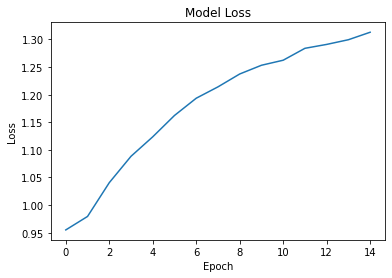

In [ ]:
from matplotlib import pyplot as plt
plt.plot(loss_history)
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

### lets check if we can use GPU

In [ ]:
tf.config.list_physical_devices()

In [17]:
## let's try predicting

def preprocess(text):
    tokenize =  np.array(tokenizer.texts_to_sequences(text)) - 1
    return tf.one_hot(tokenize,max_id)


In [18]:
x_new = preprocess(["How are yo"])
x_new

<tf.Tensor: shape=(1, 10, 39), dtype=float32, numpy=
array([[[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.

In [19]:
y_pred = np.argmax(model.predict(x_new), axis = 1)
y_pred

NameError: ignored

In [ ]:
tokenizer.sequences_to_texts(y_pred + 1)[0][-1]

' '

In [20]:
def next_char(model,text, temperature = 1):
    x_new = preprocess([text])
    y_proba = model.predict(x_new)[0,-1:,:]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits,num_samples=1) + 1
    return tokenizer.sequences_to_texts(char_id.numpy())[0]

In [21]:
def complete_text(model,text, n_chars = 50,temperature = 1):
    for _ in range(n_chars):
        text += next_char(model,text,temperature)
    return text

In [22]:
print(complete_text("Queen",n_chars=5,temperature=0.4))

TypeError: ignored

In [ ]:
print(complete_text("w",n_chars=5,temperature=1))

34857/34857 [==============================] - 145s 4ms/step
wo a a


In [ ]:
model.save("128_2_hidden_GRU_Shackspear_model")

INFO:tensorflow:Assets written to: 128_2_hidden_GRU_Shackspear_model\assets


INFO:tensorflow:Assets written to: 128_2_hidden_GRU_Shackspear_model\assets


### loading the trained model

OSError: ignored

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/project3_rnn/128_2_hidden_GRU_Shackspear_model")

In [6]:
### Check if we have GPU
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [6]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
6.343770006
GPU (s):
0.09363167000000772
GPU speedup over CPU: 67x


In [23]:
text = complete_text(loaded_model,"run",n_chars = 100,temperature=1)

1/1 [==============================] - 0s 24ms/step


In [24]:
print(text)

rund
betution, the great at the seasel like a create
to wome glesting here!

caliban:
foul this island;


In [36]:
print(loaded_model.history.params)

{'verbose': 1, 'epochs': 1, 'steps': 1}


In [80]:
loaded_model.history["loss"]

TypeError: ignored

### running all the code together

In [2]:
# -*- coding: utf-8 -*-
"""char_rnn_shackspear.ipynb

Automatically generated by Colaboratory.

Original file is located at open it with Co lab notebook
    https://drive.google.com/file/d/1d8cjgVj7H297jaWzbrDM7kX26nuCofoy/view?usp=sharing

## imports
"""

import tensorflow as tf
from tensorflow import keras
import numpy as np
import time



# preproess the text into one-hot
def preprocess(text):
    tokenize =  np.array(tokenizer.texts_to_sequences(text)) - 1
    return tf.one_hot(tokenize,max_id)

# get next char 
def next_char(model,text, temperature = 1):
    x_new = preprocess([text]) 
    y_proba = model.predict(x_new)[0,-1:,:] # get the probiliaty distrubtion for last char
    rescaled_logits = tf.math.log(y_proba) / temperature # rescale the logithiem of predicted probs
    char_id = tf.random.categorical(rescaled_logits,num_samples=1) + 1 # generates a single integer that corresponds to the predicted next char in the sequence
    return tokenizer.sequences_to_texts(char_id.numpy())[0] # return the next predicted char

# get the text of a number of char passing to it a certain char limits and temperature to control how conservaite or exploratory the model should be.
def complete_text(model,text, n_chars = 50,temperature = 1):
    for _ in range(n_chars):
        text += next_char(model,text,temperature)
    return text



### This code was use in Co Lab notebook. Please look at the link above to access the notebook
### Check if we have GPU

# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

# ### mount google drive

# from google.colab import drive
# drive.mount('/content/drive')






## let's read the text file
filepath = "./tiny-shakespeare.txt"
with open(filepath) as file:
    shake_text = file.read()

#print(shake_text)

# lets encode every characeter in the text using keras tokeninzer

tokenizer = keras.preprocessing.text.Tokenizer(char_level = True) # char level true for Char-CNN
tokenizer.fit_on_texts([shake_text])

#tokenizer.get_config()

# """#### covert from seq to text and text to seq"""

# tokenizer.texts_to_sequences(["First"])

# tokenizer.sequences_to_texts([[20, 6, 9, 8, 3]])


# now that we have tokenized the text, let's encode the full text so that each character represented by it's id
[encoded] = np.array(tokenizer.texts_to_sequences([shake_text])) - 1 # substract one to get id's from 0-38 rather than 1-39

max_id = np.max(encoded) + 1

# in case we wanted to split our data.
dataset_size = 100
train_size = len(encoded) * dataset_size // 100

# we use 100% of the data for training. 
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

## now that we have got our train dataset, let's chop our data into windows

# lets used the data windows method to convert the the long sequence of chars into smaller once
n_steps = 100
window_length = n_steps + 1 # the windows length would be 101
dataset = dataset.window(window_length,shift = 1,drop_remainder=True) # creates nonoverlapping windows in our dataset such that
# they go from 0-100 .. 1-101 .. 2-102

# now let's convert the nested dataset into flat dataset
dataset = dataset.flat_map(lambda window: window.batch(window_length))

# make a random seed
np.random.seed(42)
tf.random.set_seed(42)

# lets use batches and batch our data
batch_size = 32
# shuffle the windows and put it in batches
dataset = dataset.shuffle(10000).batch(batch_size)
# put the sequence into input sequence , and target.  
dataset = dataset.map(lambda windows : (windows[:,:-1], windows[:,1:]))

# lets convert our data to one-hot
dataset = dataset.map(lambda X_batch, Y_batch : (tf.one_hot(X_batch,depth = max_id), Y_batch))
# add prefitching so that we can overlap the data to imporve training performace
dataset = dataset.prefetch(1)

# for e in dataset.take(3):
#     print(e)

# example shapes output for X_batch and Y_batch
for X_batch,Y_batch in dataset.take(1):
    print(X_batch.shape,Y_batch.shape)

"""## lets train our model"""


timestr = time.strftime("%Y%m%d-%H%M%S")

num_hidden_neruons = 128
n_epochs = 5
path = f"./project3_rnn_ep_{n_epochs}_{num_hidden_neruons}_2H_{timestr}"

# define the RNN model
def fit_shackspear_rnn(dataset,num_hidden_neruons = num_hidden_neruons,n_epochs = n_epochs,filepath = path):
  # use TF Sequential API and make two hidden layers for the RNN. for Output layer use softmax activation.
  model = keras.models.Sequential([
    keras.layers.GRU(num_hidden_neruons,return_sequences=True,input_shape = [None, max_id]),
    keras.layers.GRU(num_hidden_neruons,return_sequences = True),
    keras.layers.TimeDistributed(keras.layers.Dense(max_id,activation="softmax"))
  ])
  # compile the model with a loss sparse_categorical_crossentropy and adam optimizer

  model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam")

  # fit the the model
  model.fit(dataset,epochs = n_epochs)

  # save the model. 
  model.save(filepath)

  return model

Shakespear_RNN = fit_shackspear_rnn(dataset,n_epochs=5)


# save the model
Shakespear_RNN.save(path)



### Loss:
loss_history = Shakespear_RNN.history.history["loss"]
# print tht loss average
avg_loss = np.mean(loss_history)
print(f"Average Loss is {round(avg_loss,4)}")


## let's predict what our model learned.


texts_to_predict = ["How are yo", "Oman" , "sleep","Queen", "King"] # tokens to test our model with
outputs = [] # append the predictions 


### loading last trained model
n_chars = 100
for i in texts_to_predict:
  outputs.append(complete_text(Shakespear_RNN,i,n_chars = n_chars, temperature=1))

print(f"The RNN will predict the next sequence of {n_chars} chars")
print("_" * 50)
for i in range(len(outputs)):
  print(f"input \"{texts_to_predict[i]}\" predictions is")
  print(outputs[i])
  print("=" * 50)


(32, 100, 39) (32, 100)
Epoch 1/5
     44/Unknown - 15s 169ms/step - loss: 3.1965

KeyboardInterrupt: 